# Gym solving - TRPO
---
- TRPO(Trust Region Policy Optimization)

- 개념 및 구현이 상당히 까다로움, [참고링크](https://github.com/ikostrikov/pytorch-trpo/blob/master/trpo.py)

- [linesearch](https://convex-optimization-for-all.github.io/)

In [1]:
# 해당 셀은 필자의 Jupyter notebook 환경 문제로 인해 작성되었습니다
import os
try:
    os.environ["DISPLAY"]
except:
    os.environ["SDL_VIDEODRIVER"] = "dummy"
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import gym
import copy
import sys
sys.path.append('../material')
from utils import moving_average, discounted_reward, FIFO

from IPython.display import clear_output
from IPython.display import Video

In [3]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)

cpu


In [4]:
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
np.random.seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
env = gym.make('CartPole-v0')
env.seed(123)
env._max_episode_steps=500

/home/hyunseok.hwang/anaconda3/envs/RL_scratch/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


# TRPO agent 생성
---
Actor와 Critic에 대한 model을 따로 분리하여 작성합니다

In [6]:
class TRPO_actorAgent(nn.Module):
    def __init__(self, state_shape, n_actions):
        super(TRPO_actorAgent,self).__init__()
        '''
        입력변수
            state_shape: state 차원 -> [위치, 속도, 각도, 각속도]
            output_dim: actor 차원 -> [왼쪽, 오른쪽]
            device : cpu, cuda device정보 
        N.N 구조
            2 - hidden layers, 64 nodes
            Activation function -> Relu
        '''
        self.state_shape = state_shape
        self.n_actions = n_actions
        
        self.seq = nn.Sequential(
            nn.Linear(self.state_shape,128), 
            nn.ReLU(),
            nn.Linear(128,self.n_actions)
        )
        
    def forward(self, state_t):
        '''
        입력인자
            state_t : 상태([batch,state_shape]), torch.tensor
        출력인자
            policy : 정책([batch,n_actions]), torch.tensor
        '''
        policy = self.seq(state_t)
        return policy


    def sample_actions(self,state_t):
        '''
        입력인자
            state_t : 상태([1,state_shape]), torch.tensor
        출력인자
            action_t : 행동함수 using torch.multinomial
        '''
        policy = self.forward(state_t)
        soft_policy = F.softmax(policy,dim=-1)
        action = torch.multinomial(soft_policy, num_samples=1).item()
        return action
    
class TRPO_criticAgent(nn.Module):
    def __init__(self,state_shape):
        super(TRPO_criticAgent,self).__init__()
        '''
        입력변수
            state_shape: state 차원 -> [위치, 속도, 각도, 각속도]
        N.N 구조
            2 - hidden layers, 64 nodes
            Activation function -> Relu
        '''
        self.state_shape = state_shape        
        self.seq = nn.Sequential(
            nn.Linear(self.state_shape,128), 
            nn.ReLU(),
            nn.Linear(128,1)
        )
        
    def forward(self, state_t):
        '''
        입력인자
            state_t : 상태([batch,state_shape]), torch.tensor
        출력인자
            value : 가치함수([batch,1]), torch.tensor
        '''
        value = self.seq(state_t)
        return value

In [7]:
gamma=0.99
epsilon = 1e-03
delta = 1e-05

state = env.reset()
num_state = state.shape[0]
num_action = env.action_space.n
learning_rate = 5e-04
max_episode = 1000
update_per_episode=10

# TRPO 유틸들을 정리해봅시다
--- 
ikostrikov + TianhongDai - Reference

In [62]:
# conjugated gradient
def conjugated_gradient(fvp, b, update_steps, obs, pi_old, residual_tol=1e-10):
    # the initial solution is zero
    x = torch.zeros(b.size(), dtype=torch.float32)
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)
    for i in range(update_steps):
        fv_product = fvp(p, obs, pi_old)
        alpha = rdotr / torch.dot(p, fv_product)
        x = x + alpha * p
        r = r - alpha * fv_product
        new_rdotr = torch.dot(r, r)
        beta = new_rdotr / rdotr 
        p = r + beta * p
        rdotr = new_rdotr
        # if less than residual tot.. break
        if rdotr < residual_tol:
            break
    return x

def set_flat_params_to(model, flat_params):
    prev_indx = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(flat_params[prev_indx:prev_indx + flat_size].view(param.size()))
        prev_indx += flat_size

# line search
def line_search(model, loss_fn, x, full_step, expected_rate, obs, adv,  pi_old, max_backtracks=10, accept_ratio=0.1):
    #fval = loss_fn(obs, adv, actions, pi_old).data
    fval = loss_fn(obs, adv, pi_old).data
    for (_n_backtracks, stepfrac) in enumerate(0.5**np.arange(max_backtracks)):
        xnew = x + stepfrac * full_step
        set_flat_params_to(model, xnew)
        #new_fval = loss_fn(obs, adv, actions, pi_old).data
        new_fval = loss_fn(obs, adv, pi_old).data
        actual_improve = fval - new_fval
        expected_improve = expected_rate * stepfrac
        ratio = actual_improve / expected_improve
        if ratio.item() > accept_ratio and actual_improve.item() > 0:
            return True, xnew
    return False, x

In [80]:
gamma=0.99
scheduler_gamma=0.999
scheduler_step=10
epsilon = 1e-03
eps = 0.2
value_ratio=0.5

state = env.reset()
num_state = state.shape[0]
num_action = env.action_space.n
learning_rate = 1e-04
max_episode = 1000

# Method 1 - TRPO vine
---
Objective function

$J = \mathbb{E}[\frac{\pi{(a \vert s)}}{\pi_{old}(a \vert s)}A(s,a)]-KL(\pi_{old}{( \cdot \vert s)}|\pi( \cdot \vert s)) $

where,

$KL(\pi_{old}{( \cdot \vert s)}|\pi( \cdot \vert s)) \leq \delta$

In [90]:
actor = TRPO_actorAgent(num_state,num_action).to(device) # 이 친구는 Conjugate Gradient method로 해결 -> optimizer 사용하지 x
old_actor = TRPO_actorAgent(num_state,num_action).to(device) # Old policy를 계산하기 위한 network
old_actor.load_state_dict(actor.state_dict())

critic = TRPO_criticAgent(num_state).to(device)
critic_optimizer = optim.Adam(critic.parameters(),lr=learning_rate)

In [91]:
#def actor_surrogate_loss(states, advantages, actions, pi_old):
def actor_surrogate_loss(states, advantages, pi_old):
    policy = actor(states)
    log_policy = F.log_softmax(policy,dim=-1)
    old_policy = F.log_softmax(pi_old,dim=-1)
    surr_loss = -torch.exp(log_policy - old_policy)*advantages
    return surr_loss.mean()

def get_kl(states,pi_old):
    # 원본 코드에서는 normal distribution으로 상정하고 문제를 해결합니다.
    pi_new = actor(states)
    pi_new = F.softmax(pi_new,dim=-1)
    pi_old = F.softmax(pi_old,dim=-1) 

    kl_div = torch.sum(pi_new*(torch.log(pi_new)-torch.log(pi_old)),dim=-1)
    return kl_div.mean()

def fisher_vector_product(input_values, states, pi_old, damping=1e-01):
    kl = get_kl(states,pi_old)

    # KL gradient의 2차 미분을 계산해봅시다.
    kl_grads = torch.autograd.grad(kl, actor.parameters(), create_graph=True)
    flat_kl_grads = torch.cat([grad.view(-1) for grad in kl_grads])
    kl_v = (flat_kl_grads * torch.autograd.Variable(input_values)).sum()
    kl_second_grads = torch.autograd.grad(kl_v, actor.parameters())
    flat_kl_second_grads = torch.cat([grad.contiguous().view(-1) for grad in kl_second_grads]).data
    flat_kl_second_grads +=  damping*input_values
    return flat_kl_second_grads

def TRPO_agentupdate(actor, loss_fn, states, pi_old, advantages, max_kl=1e-02):
    # loss 함수 -> gradient 및 flat화
    #surr_loss = loss_fn(states, advantages, actions, pi_old)
    surr_loss = loss_fn(states, advantages, pi_old)
    surr_grad = torch.autograd.grad(surr_loss, actor.parameters())
    flat_surr_grad = torch.cat([grad.view(-1) for grad in surr_grad]).data
    
    # fisher vector product -> Computation Gradient 
    nature_grad = conjugated_gradient(fisher_vector_product, -flat_surr_grad,10, states, pi_old)

    # Searching scale
    non_scale_kl = 0.5*(nature_grad*fisher_vector_product(nature_grad, states, pi_old)).sum(0,keepdim=True)
    scale_ratio = torch.sqrt(non_scale_kl/max_kl)
    final_nature_grad = nature_grad / scale_ratio[0]

    # Line search 학습률 계산
    expected_improve = (-flat_surr_grad * nature_grad).sum(0, keepdim=True) / scale_ratio[0]

    # Update 이전의 parameter 추출 
    prev_params = torch.cat([param.data.view(-1) for param in actor.parameters()])

    # update -> parmaeter 원복
    success, new_params = line_search(actor, actor_surrogate_loss, prev_params, \
                                      final_nature_grad, expected_improve, states, \
                                      advantages, pi_old)
                                      #advantages, actions, pi_old)
    set_flat_params_to(actor,new_params)

def TRPO_criticupdate(critic, state, td_target,num_iter=5):
    value = critic(state)
    for _ in range(num_iter):
        value_loss = torch.mean((td_target-value)**2)
        critic_optimizer.zero_grad()
        value_loss.item()
        critic_optimizer.step()

def TRPO_update(histories, gamma=0.99):
    '''
    TRPO update를 시행합니다.
    actor, critic에 해당하는 모델은 앞서 전역변수로 정의되었기에 따로 함수 인자로 받지 않음
    입력인자
        histories: 전체 학습과정에서 얻은 학습에 필요한 내용들
        num_update: 에피소드당 actor, critic을 update할 횟수를 지정 기본값 10회
    출력인자
        actor_loss - 가능?
        critic_loss - 가능?
    '''
    old_actor.load_state_dict(actor.state_dict()) # Update이전 동기화

    states, actions, rewards, next_states, dones = histories
    torch_state = torch.Tensor(states).to(device)
    torch_action = torch.LongTensor(actions).to(device)
    torch_reward = torch.Tensor(rewards).to(device).view(-1,1)
    torch_next_state = torch.Tensor(next_states).to(device)
    torch_dones = torch.Tensor(dones).to(device).view(-1,1)
    torch_dones = 1-torch_dones

    # Advantage 따로 계산합니다! + Policy_old까지  
    value = critic(torch_state)
    next_value = critic(torch_next_state)
    policy = old_actor(torch_state)
    policy_old = F.softmax(policy,dim=-1).detach()

    returns = torch.Tensor(discounted_reward(torch_reward)).view(-1,1)
    td_target = returns + gamma*value
    torch_advantage = td_target - next_value
    torch_advantage = (torch_advantage - torch_advantage.mean())/torch_advantage.std()
    
    TRPO_agentupdate(actor, actor_surrogate_loss, torch_state, policy_old, torch_advantage)
    TRPO_criticupdate(critic, torch_state,td_target)

990번째 에피소드 결과
최근 10 에피소드 보상평균 = 31.1


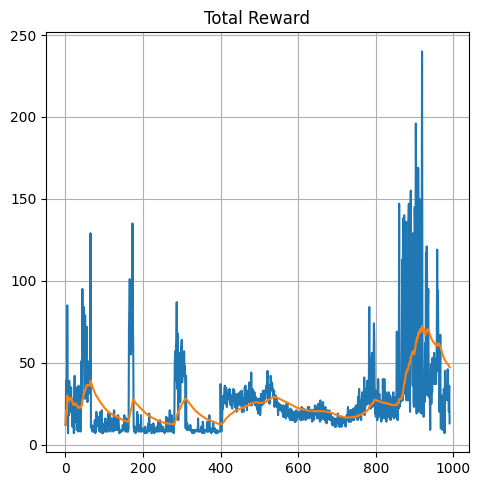

In [92]:
reward_record, loss_record, critic_record, entropy_record = [], [], [], []
states, actions, rewards, next_states, dones = [],[],[],[], []
for ep in range(max_episode):
    total_reward = 0
    state = env.reset()

    while True:
        torch_state = torch.Tensor(state[None]).to(device)
        action =  actor.sample_actions(torch_state)
        next_state, reward, done, _ = env.step(action)
        
        states = FIFO(state, states,1000)
        actions = FIFO(action, actions,1000)
        rewards = FIFO(reward, rewards,1000)
        next_states = FIFO(next_state, next_states,1000)
        dones = FIFO(done, dones,1000)

        if done:
            break

        state = next_state
        total_reward += reward
    reward_record.append(total_reward)
    history = (states, actions, rewards,next_states, dones)
    # Episode finish -> update agent model
    TRPO_update(history, update_per_episode)

    if ep % 10 == 0:
        clear_output(True)
        print(f'{ep}번째 에피소드 결과')
        print(f'최근 10 에피소드 보상평균 = {np.mean(reward_record[-10:])}')

        plt.figure(figsize=[12, 12])
        
        plt.subplot(2,2,1)
        plt.title("Total Reward")
        plt.plot(reward_record)
        plt.plot(moving_average(reward_record))
        plt.grid()
        plt.show()
    
    if np.mean(reward_record[-10:]) >= 400:
        best_actor = copy.deepcopy(actor)
        best_critic = copy.deepcopy(critic)
        torch.save(best_actor,'./ckpt/CartPole/TRPO_bestactor.pth')
        torch.save(best_critic, './ckpt/CartPole/TRPO_bestcritic.pth')